[1] "whoi"           "whoi2"          "jason"          "atlantis"      
 [5] "wefa_sun"       "bikepath"       "bog"            "rocky_beach"   
 [9] "eelpond_winter" "tulips"         "sunset_winter"

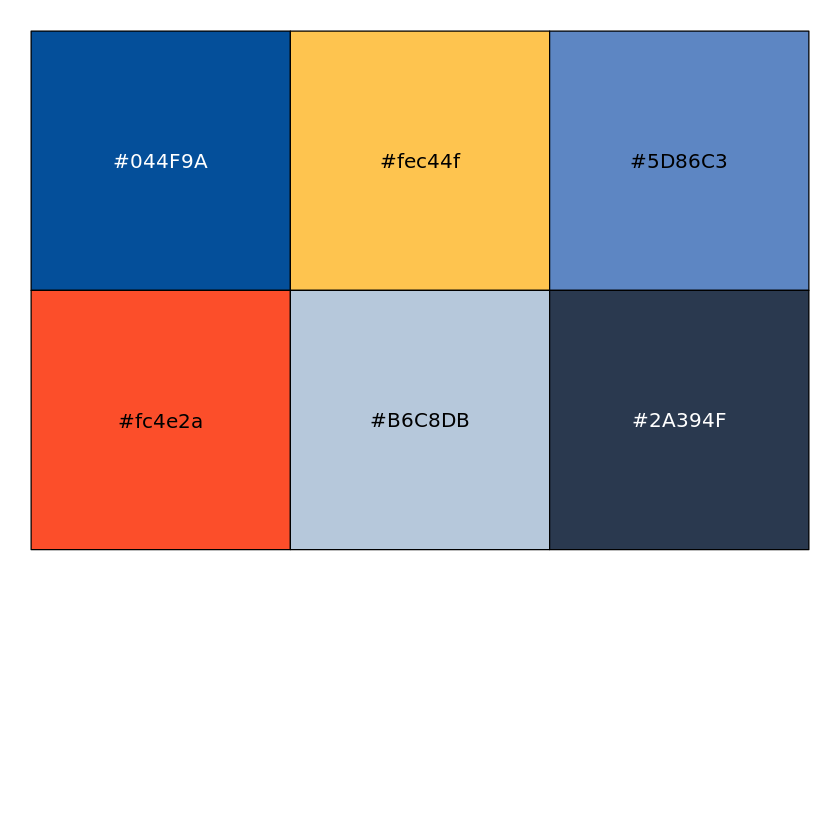

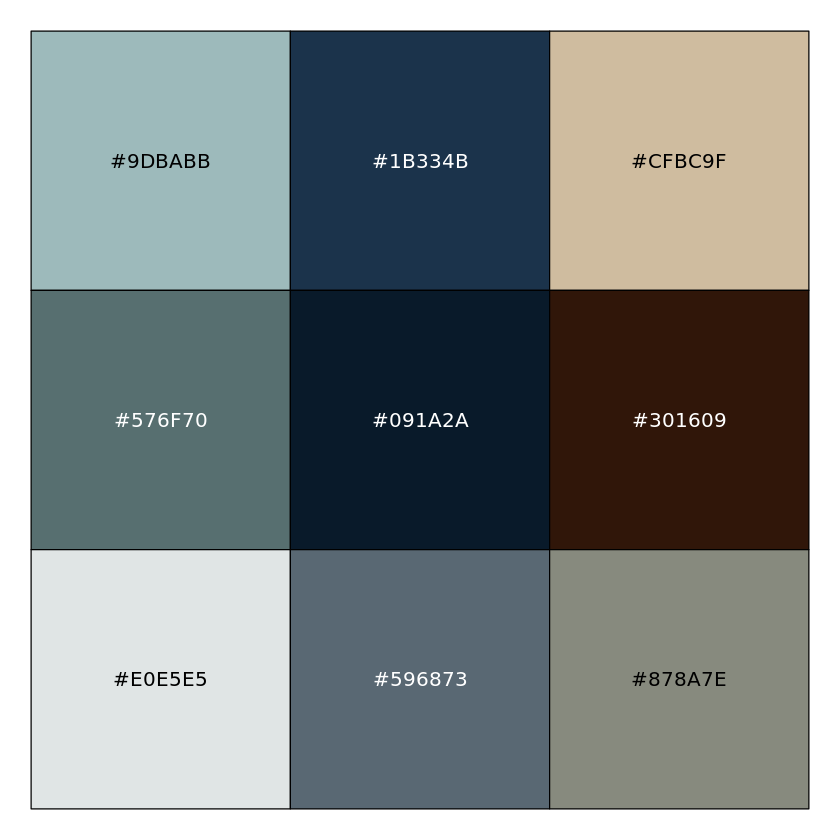

In [49]:
suppressMessages(library(dplyr))
suppressMessages(library(reshape2))
suppressMessages(library(ggplot2))
options(dplyr.summarise.inform = FALSE)# Suppress summarise info
library(UpSetR)
library(PaletteWoodsHole)
names(woodshole)
show_color(jason)
show_color(atlantis)

In [13]:
df <- read.table(file = "~/2020-osmolytes/genome-searching/predict_synthesis/predicted-bacterial-osmolyte-synthesis.tsv", 
                 sep = '\t', header = F)
dim(df)
# only keep metabs that have transporters
osmo <- c('Glycerol','Glycine betaine','Sorbitol','Mannitol','Taurine')
df <- df[, c(1,which(df[1,] %in% osmo))]
# create df for just names of metab and trans,break,syn
fn <- df[1:2,-1]
# create p/a table
pa <- df[3:dim(df)[1],]
tmp <- pa$V1; pa$V1 <- NULL
pa <- as.data.frame(sapply(pa, as.numeric))
rownames(pa) <- tmp
# create taxa table
marref <- read.delim("~/2020-osmolytes/genome-searching/MarRef_DBs/MarRef_v5.txt")
dim(marref)
# removing the marref with NA's in accession value
idx <- which(is.na(marref$assembly_accession_refseq))
marref <- marref[-idx,]
# replace rownames with accession value
rownames(marref) <- marref$assembly_accession_refseq
# rearrange so that rownames are equal to the synthesis tsv file
marref <- marref[rownames(pa),]

# finally split up p/a table by transp, break, syn
t <- which(fn[2,] == "TRANSPORT")
tr <- pa[,t]; colnames(tr) <- fn[1,t]
b <- which(fn[2,] == "BREAKDOWN")
br <- pa[,b]; colnames(br) <- fn[1,b]
s <- which(fn[2,] == "SYNTHESIS")
syn <- pa[,s]; colnames(syn) <- fn[1,s]

# check dim
dim(syn)[1] == dim(pa)[1]
dim(syn)[2] == dim(tr)[2]
dim(br)[2] == dim(tr)[2]

# check names
all(rownames(br) == marref$assembly_accession_refseq)

# add rownames back
rownames(tr) <- rownames(pa)
rownames(br) <- rownames(pa)
rownames(syn) <- rownames(pa)

[1] 899  49

[1] 970 126

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [130]:
## Adding a custom classification 
marref$custom <- marref$phylum
idx <- marref$custom == "Proteobacteria" # Split proteobacteria into delta, alpha, beta, gamma, epsilon, zeta, oligoflex
marref$custom[idx] <- marref$class[idx]

idx <- marref$kingdom == "Archaea" # combine Eury and Crenarchaeota
marref$custom[idx] <- "Archaea"

idx <- marref$custom == "Actinobacteria (Phylum)" # drop the extra label for Actinos
marref$custom[idx] <- "Actinobacteria"

unique(marref$custom)
## Create color palette for taxa
tax_color <- sunset_winter
names(tax_color) <- c("Actinobacteria", "Alphaproteobacteria","Firmicutes","Gammaproteobacteria","Other","Cyanobacteria")

[1] "Deltaproteobacteria"            "Alphaproteobacteria"           
 [3] "Betaproteobacteria"             "Cyanobacteria"                 
 [5] "Gammaproteobacteria"            "Bacteroidetes"                 
 [7] "Archaea"                        "Actinobacteria"                
 [9] "Firmicutes"                     "Thermotogae (Phylum)"          
[11] "Aquificae"                      "Calditrichaeota"               
[13] "Chlorobi"                       "Epsilonproteobacteria"         
[15] "Deferribacteres (Phylum)"       "Unclassified"                  
[17] "Planctomycetes"                 "Verrucomicrobia"               
[19] "Tenericutes"                    "Chloroflexi"                   
[21] "Spirochaetes"                   "Zetaproteobacteria"            
[23] "Deinococcus-Thermus"            "Thermodesulfobacteria (Phylum)"
[25] "Aquificae (Phylum)"             "Synergistetes"                 
[27] "Oligoflexia"                    "Fusobacteria"

Using class as id variables



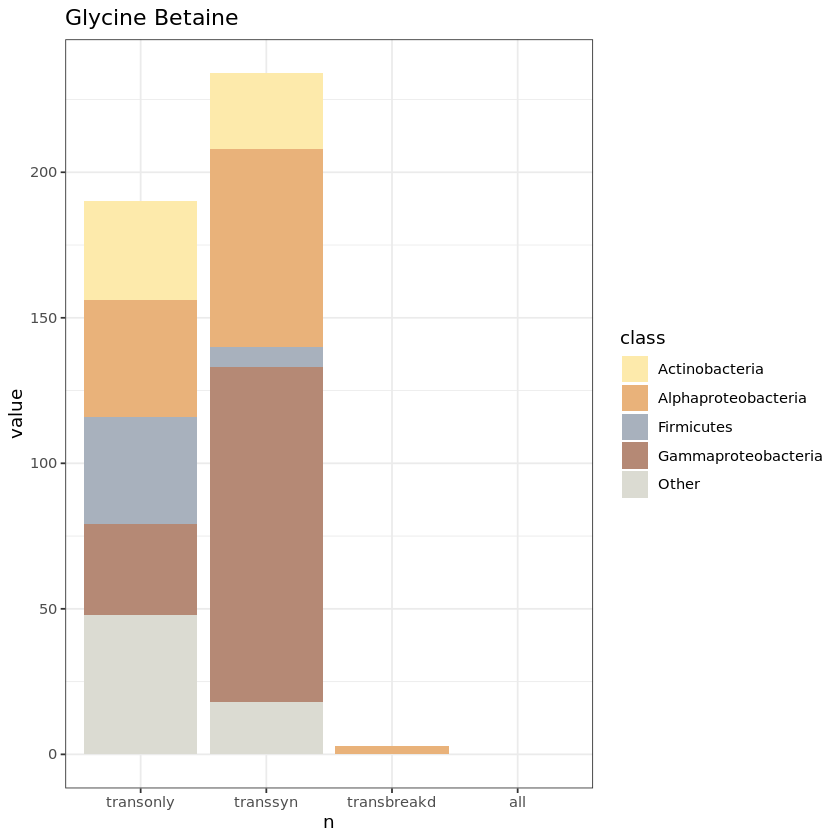

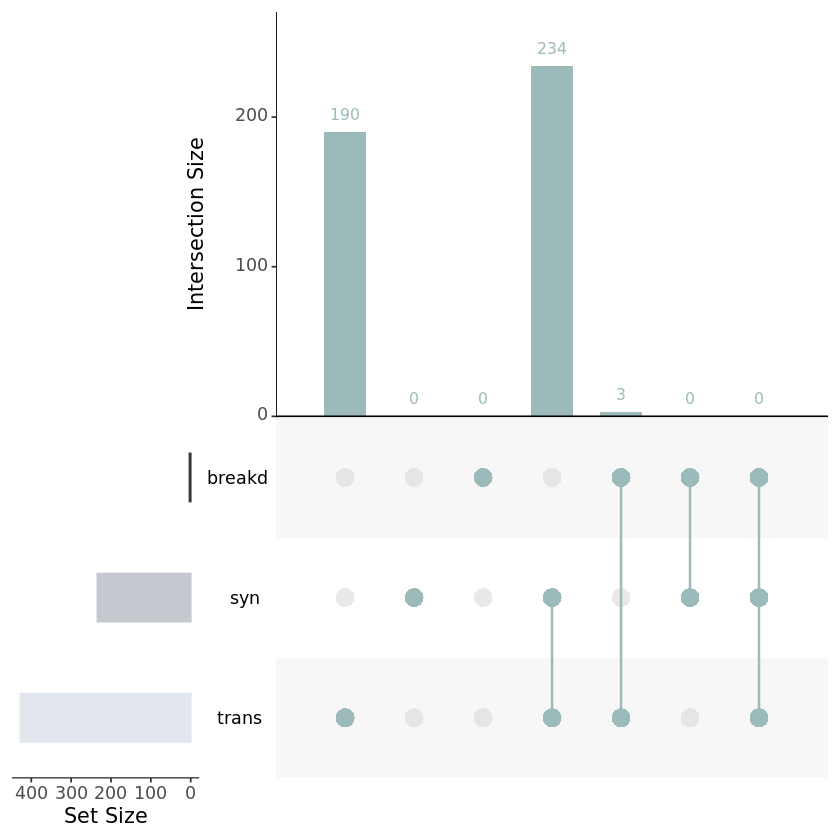

In [131]:
gcb <- data.frame(class = marref$custom, trans=tr$`Glycine betaine`, syn=syn$`Glycine betaine`, breakd=br$`Glycine betaine`)
rownames(gcb) <- rownames(pa)
gcb %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    #print() %>%
    melt() %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity")+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = tax_color)+
        theme_bw()+
        ggtitle("Glycine Betaine")+
        xlab("n")

gcb %>%
    filter(trans == 1) %>%
    upset(text.scale = 1.5, sets.bar.color = eelpond_winter[1:3], main.bar.color = atlantis[1], 
          matrix.color = atlantis[1], mb.ratio = c(0.5, 0.5), point.size = 5,
           empty.intersections = "on")

Using class as id variables



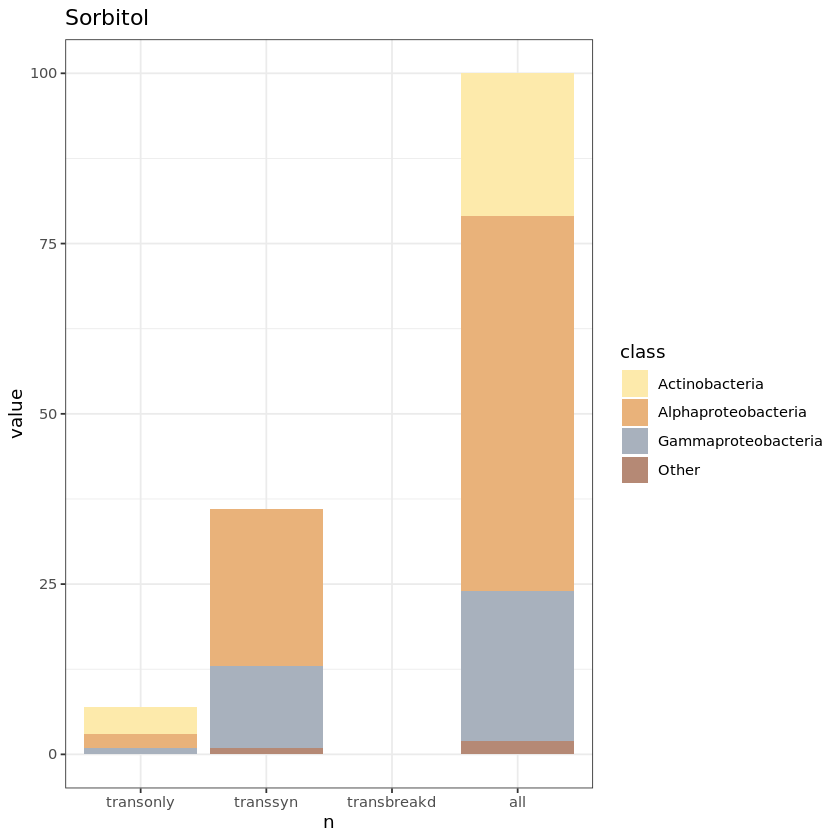

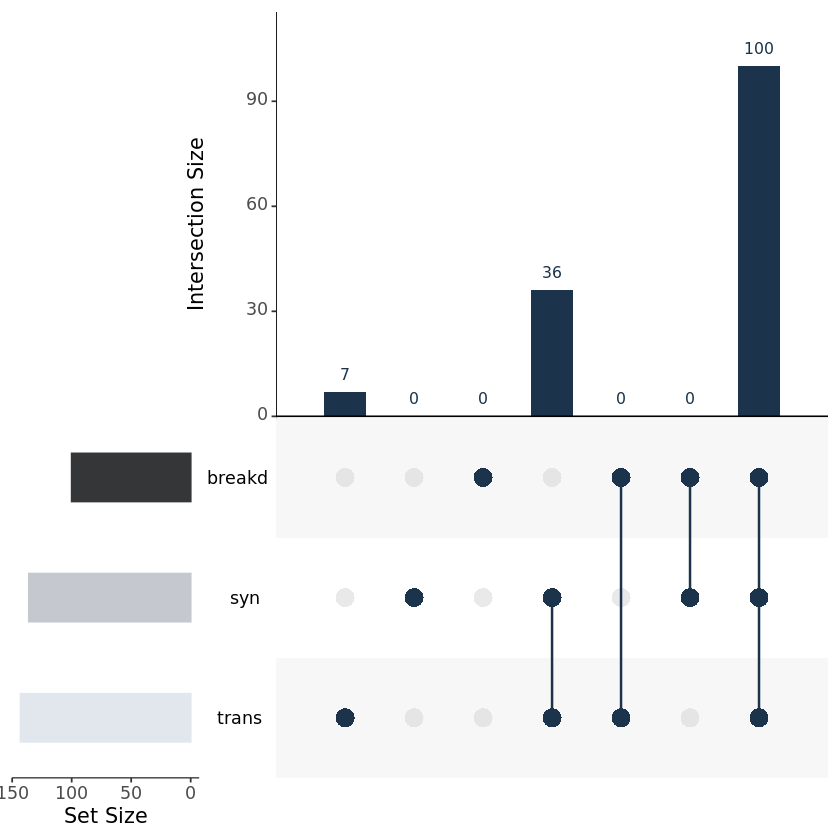

In [132]:
sorb <- data.frame(class = marref$custom, trans=tr$Sorbitol, syn=syn$Sorbitol, breakd=br$Sorbitol)
rownames(sorb) <- rownames(pa)
sorb %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    #print() %>%
    melt() %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity")+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = sunset_winter)+
        theme_bw()+
        ggtitle("Sorbitol")+
        xlab("n")

sorb %>%
    filter(trans == 1) %>%
    upset(text.scale = 1.5, sets.bar.color = eelpond_winter[1:3], main.bar.color = atlantis[2], 
          matrix.color = atlantis[2], mb.ratio = c(0.5, 0.5), point.size = 5,
           empty.intersections = "on")

Using class as id variables



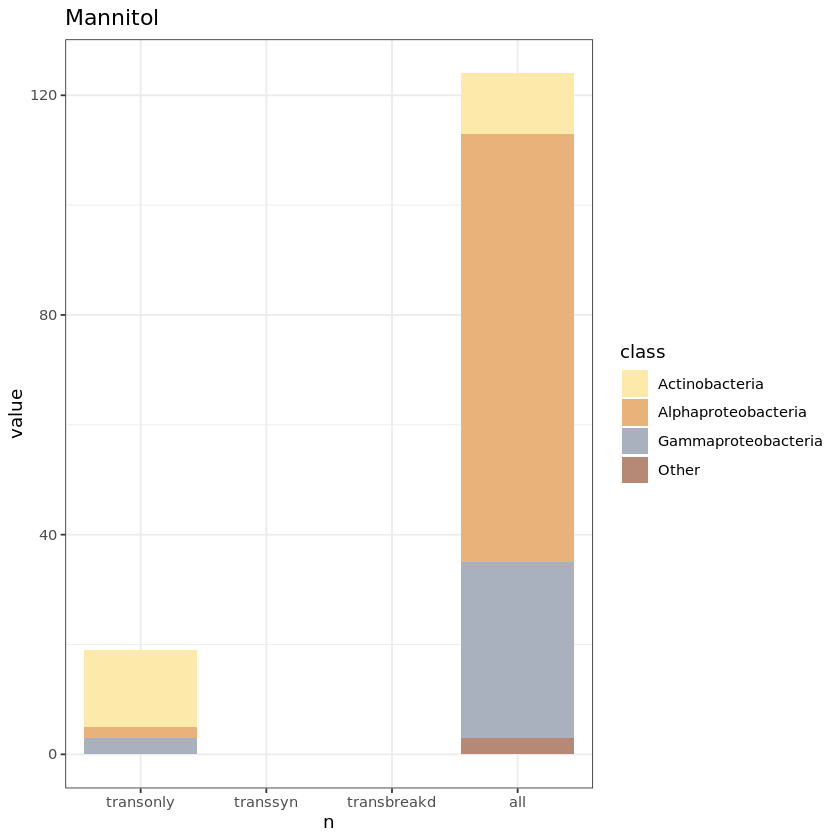

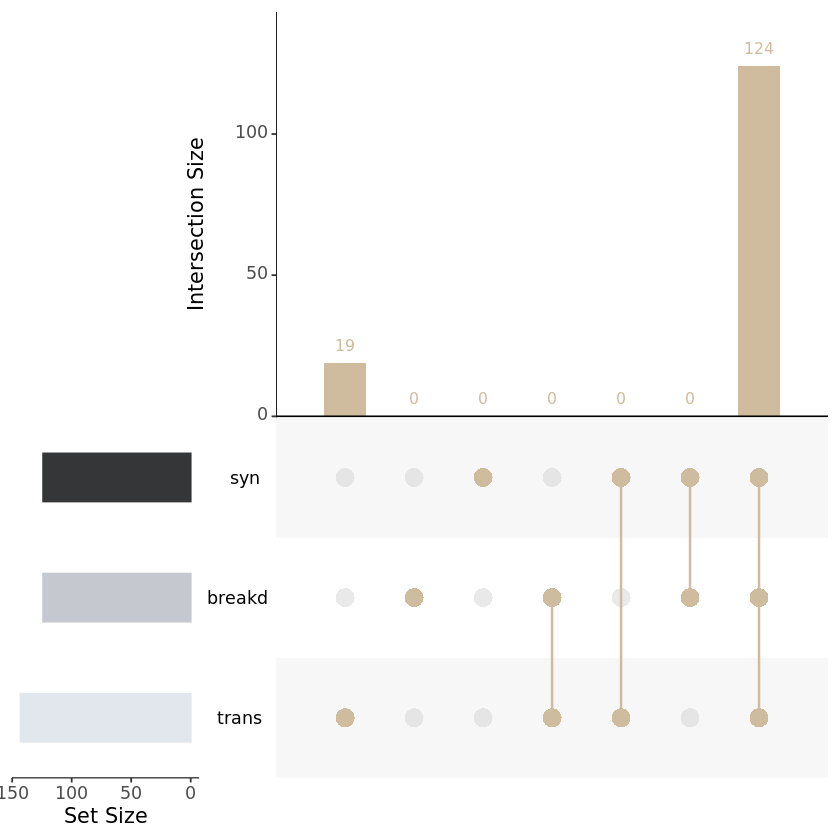

In [133]:
mann <- data.frame(class = marref$custom, trans=tr$Mannitol, syn=syn$Mannitol, breakd=br$Mannitol)
rownames(mann) <- rownames(pa)
mann %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    #print() %>%
    melt() %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity")+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = sunset_winter)+
        theme_bw()+
        ggtitle("Mannitol")+
        xlab("n")

mann %>%
    filter(trans == 1) %>%
    upset(text.scale = 1.5, sets.bar.color = eelpond_winter[1:3], main.bar.color = atlantis[3], 
          matrix.color = atlantis[3], mb.ratio = c(0.5, 0.5), point.size = 5,
           empty.intersections = "on")

Using class as id variables



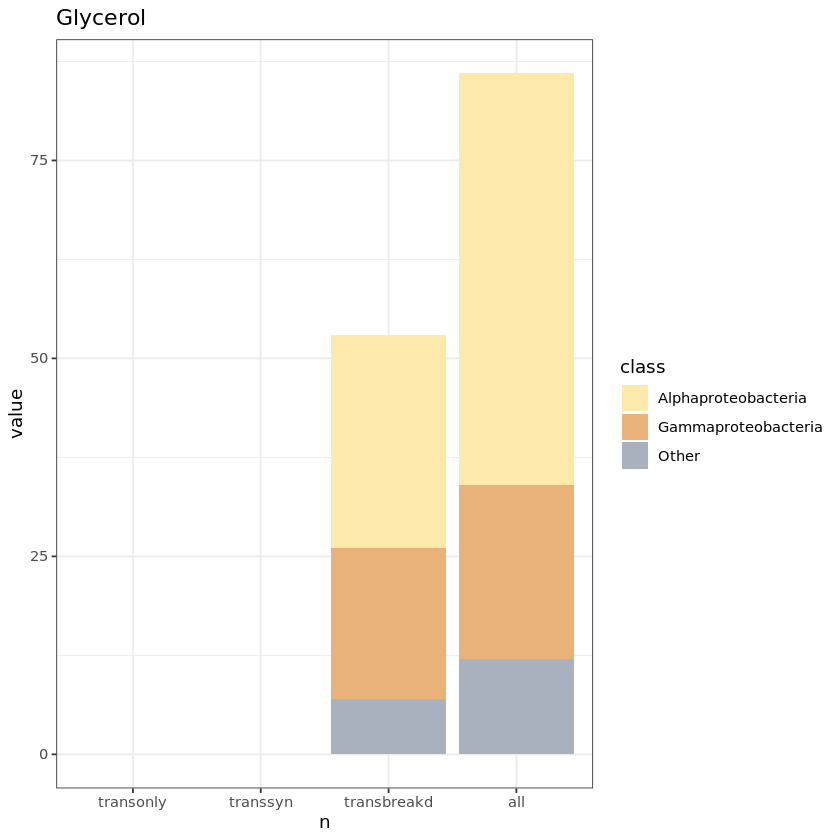

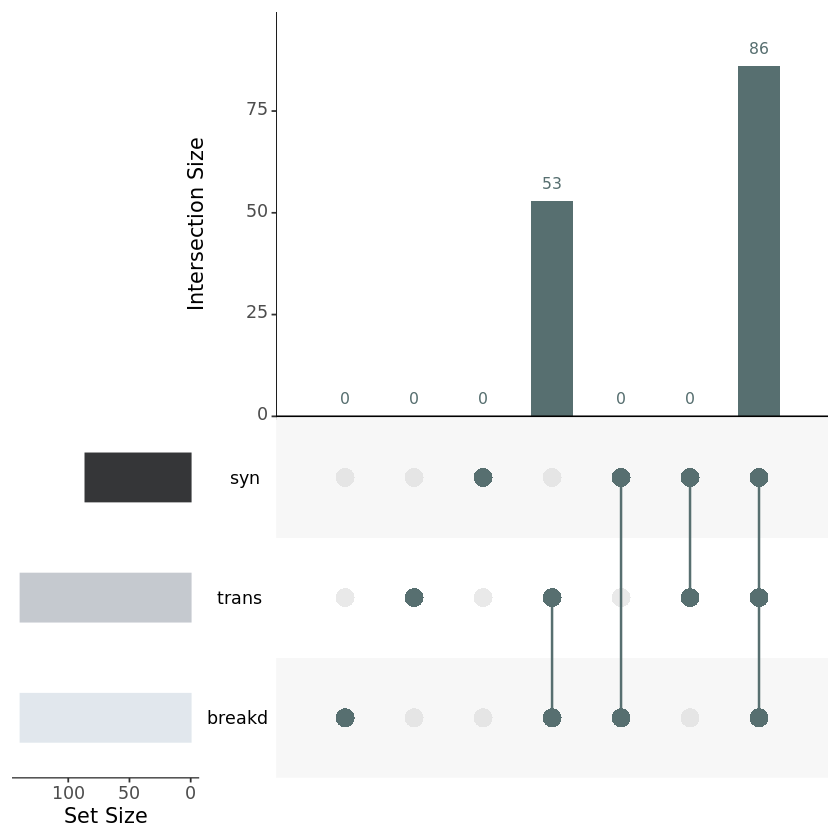

In [134]:
glyc <- data.frame(class = marref$custom, trans=tr$Glycerol, syn=syn$Glycerol, breakd=br$Glycerol)
rownames(glyc) <- rownames(pa)
glyc %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    #print() %>%
    melt() %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity")+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = sunset_winter)+
        theme_bw()+
        ggtitle("Glycerol")+
        xlab("n")

glyc %>%
    filter(trans == 1) %>%
    upset(text.scale = 1.5, sets.bar.color = eelpond_winter[1:3], main.bar.color = atlantis[4], 
          matrix.color = atlantis[4], mb.ratio = c(0.5, 0.5), point.size = 5,
           empty.intersections = "on")

Using class as id variables



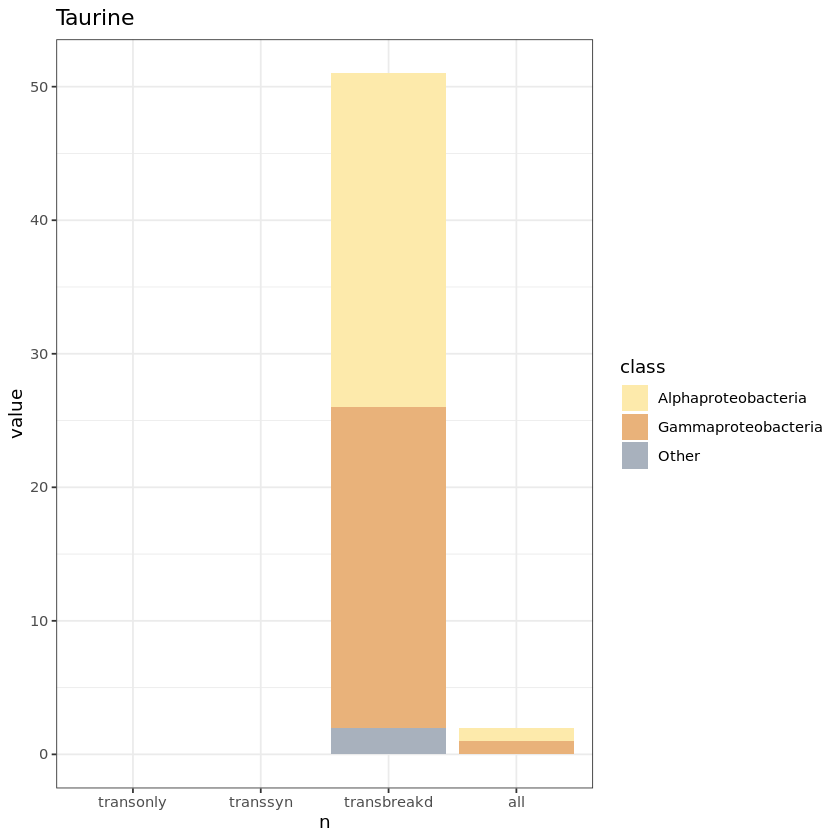

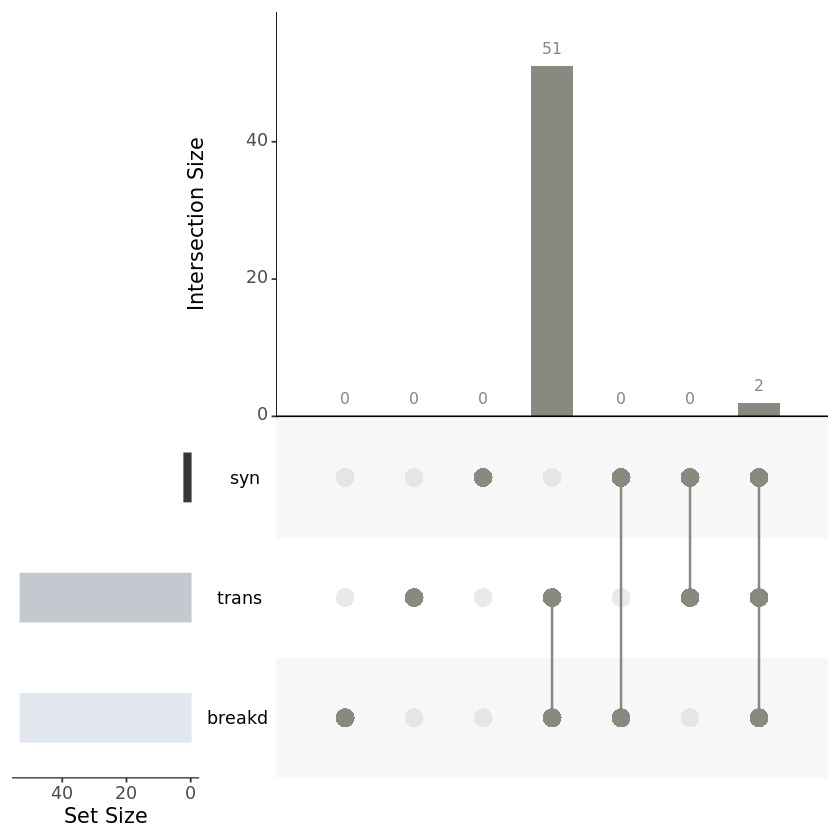

In [135]:
taur <- data.frame(class = marref$custom, trans=tr$Taurine, syn=syn$Taurine, breakd=br$Taurine)
rownames(taur) <- rownames(pa)
taur %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    #print() %>%
    melt() %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity")+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = sunset_winter)+
        theme_bw()+
        ggtitle("Taurine")+
        xlab("n")

taur %>%
    filter(trans == 1) %>%
    upset(text.scale = 1.5, sets.bar.color = eelpond_winter[1:3], main.bar.color = atlantis[9], 
          matrix.color = atlantis[9], mb.ratio = c(0.5, 0.5), point.size = 5,
           empty.intersections = "on")